# SENA - Link Prediction in Marvel Comic Universe

## Group 6:
#### Gowtham T         -  19Z214
#### Indra Shekar G    -  19Z219
#### Sanjai M          -  19Z241
#### Yogesh Kumaar R   -  19Z262
#### Manoj S           -  19Z263
#### Mathana Sekaran T -  19Z264
#### Harish N R        -  20Z431

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from node2vec import Node2Vec
from sklearn .model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [2]:
# os.makedirs('dataset')
# with zipfile.ZipFile("Dataset file/hero-network.zip","r") as zip_ref:
#     zip_ref.extractall('dataset')

In [3]:
marvel_universe=pd.read_csv('dataset/hero-network.csv')
nodes=pd.read_csv('dataset/nodes.csv')
edges=pd.read_csv('dataset/edges.csv')

In [4]:
len(marvel_universe)

574467

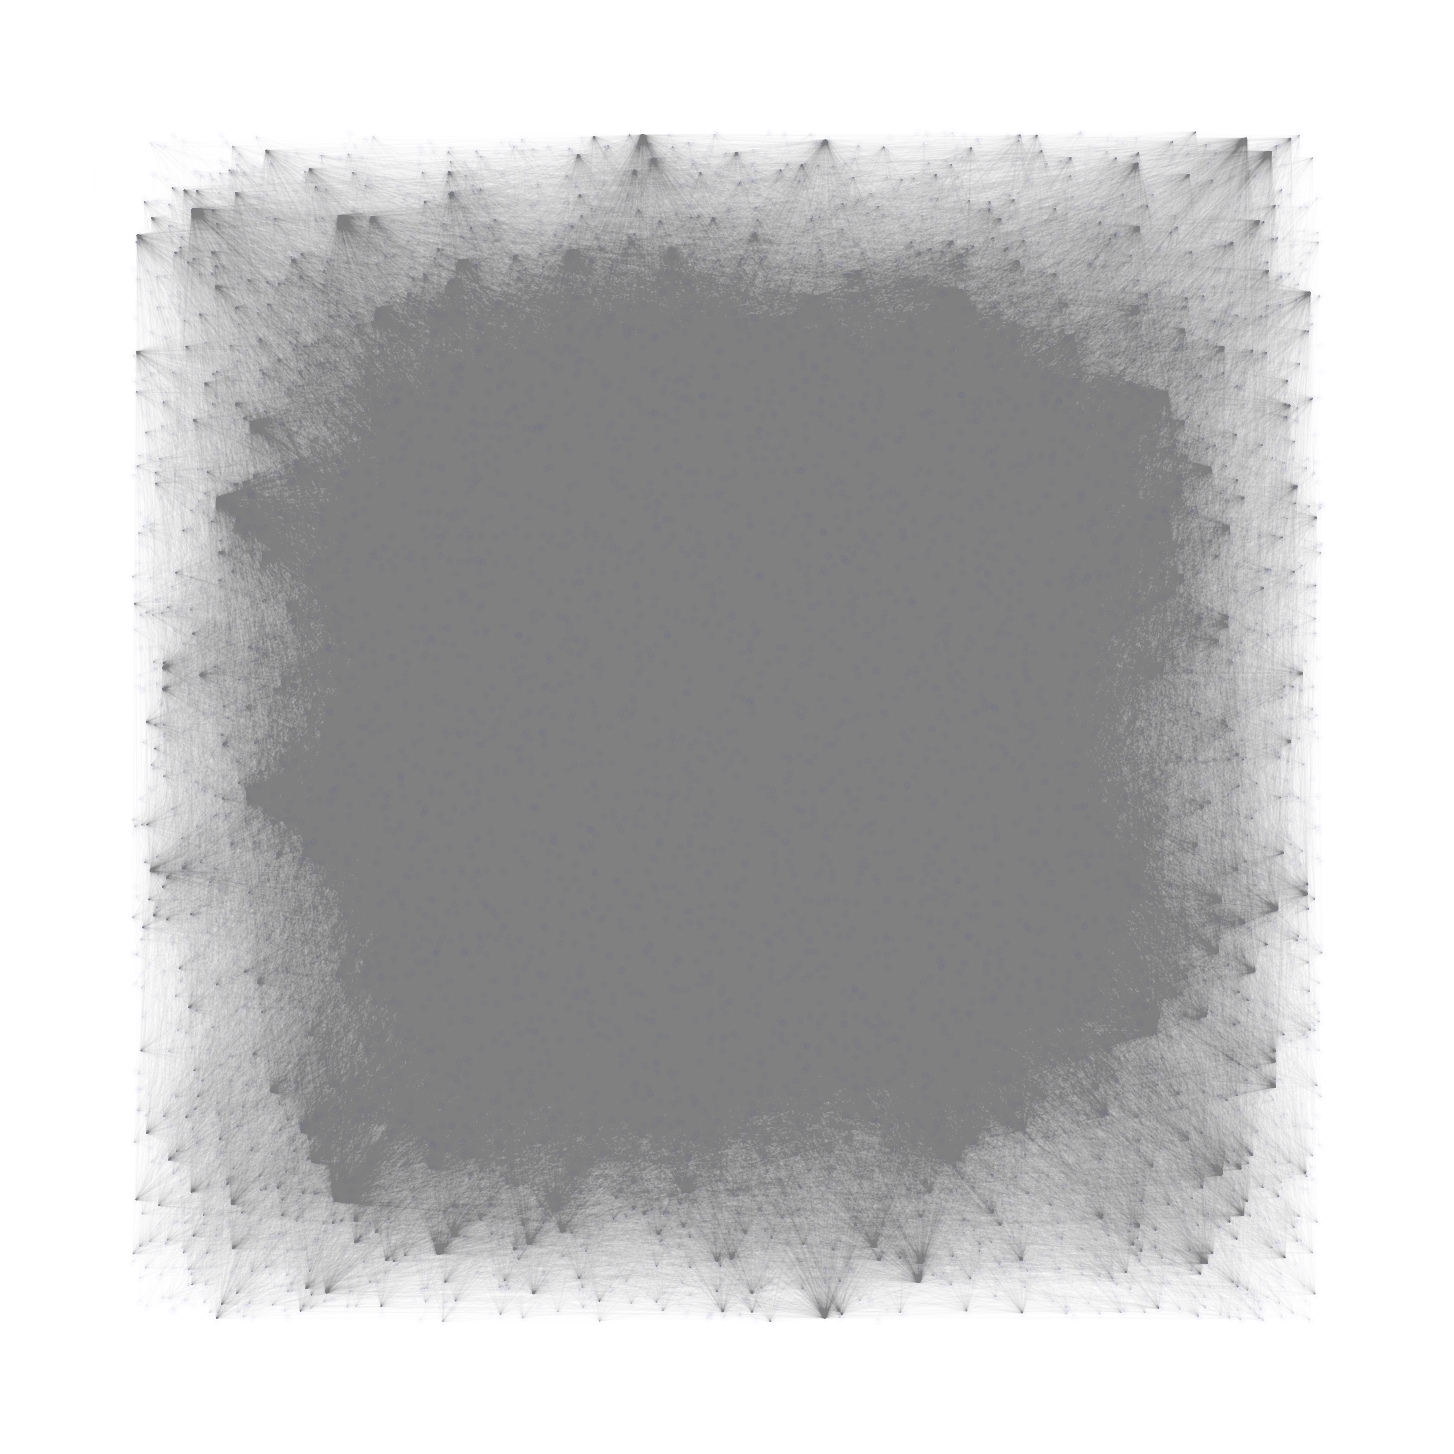

In [5]:
graph=nx.from_pandas_edgelist(marvel_universe,'hero1','hero2',create_using=nx.Graph())
plt.figure(figsize=(20,20))
pos=nx.random_layout(graph,seed=30)
nx.draw(graph, with_labels=False,  pos = pos, node_size = 40, alpha = 0.01,edge_color='grey',node_color='blue')
plt.show()


In [6]:
graph=nx.from_pandas_edgelist(marvel_universe,'hero1','hero2',create_using=nx.Graph())
nodes_to_remove=[]
for x in graph.nodes():
    if(graph.degree(x)<=500):
        nodes_to_remove.append(x)
for x in nodes_to_remove:
    graph.remove_node(x)

In [7]:
# len(nodes_to_remove)

In [8]:
marvel_universe=marvel_universe[~marvel_universe['hero1'].isin(nodes_to_remove)]
marvel_universe=marvel_universe[~marvel_universe['hero2'].isin(nodes_to_remove)]

In [9]:
len(marvel_universe)

95620

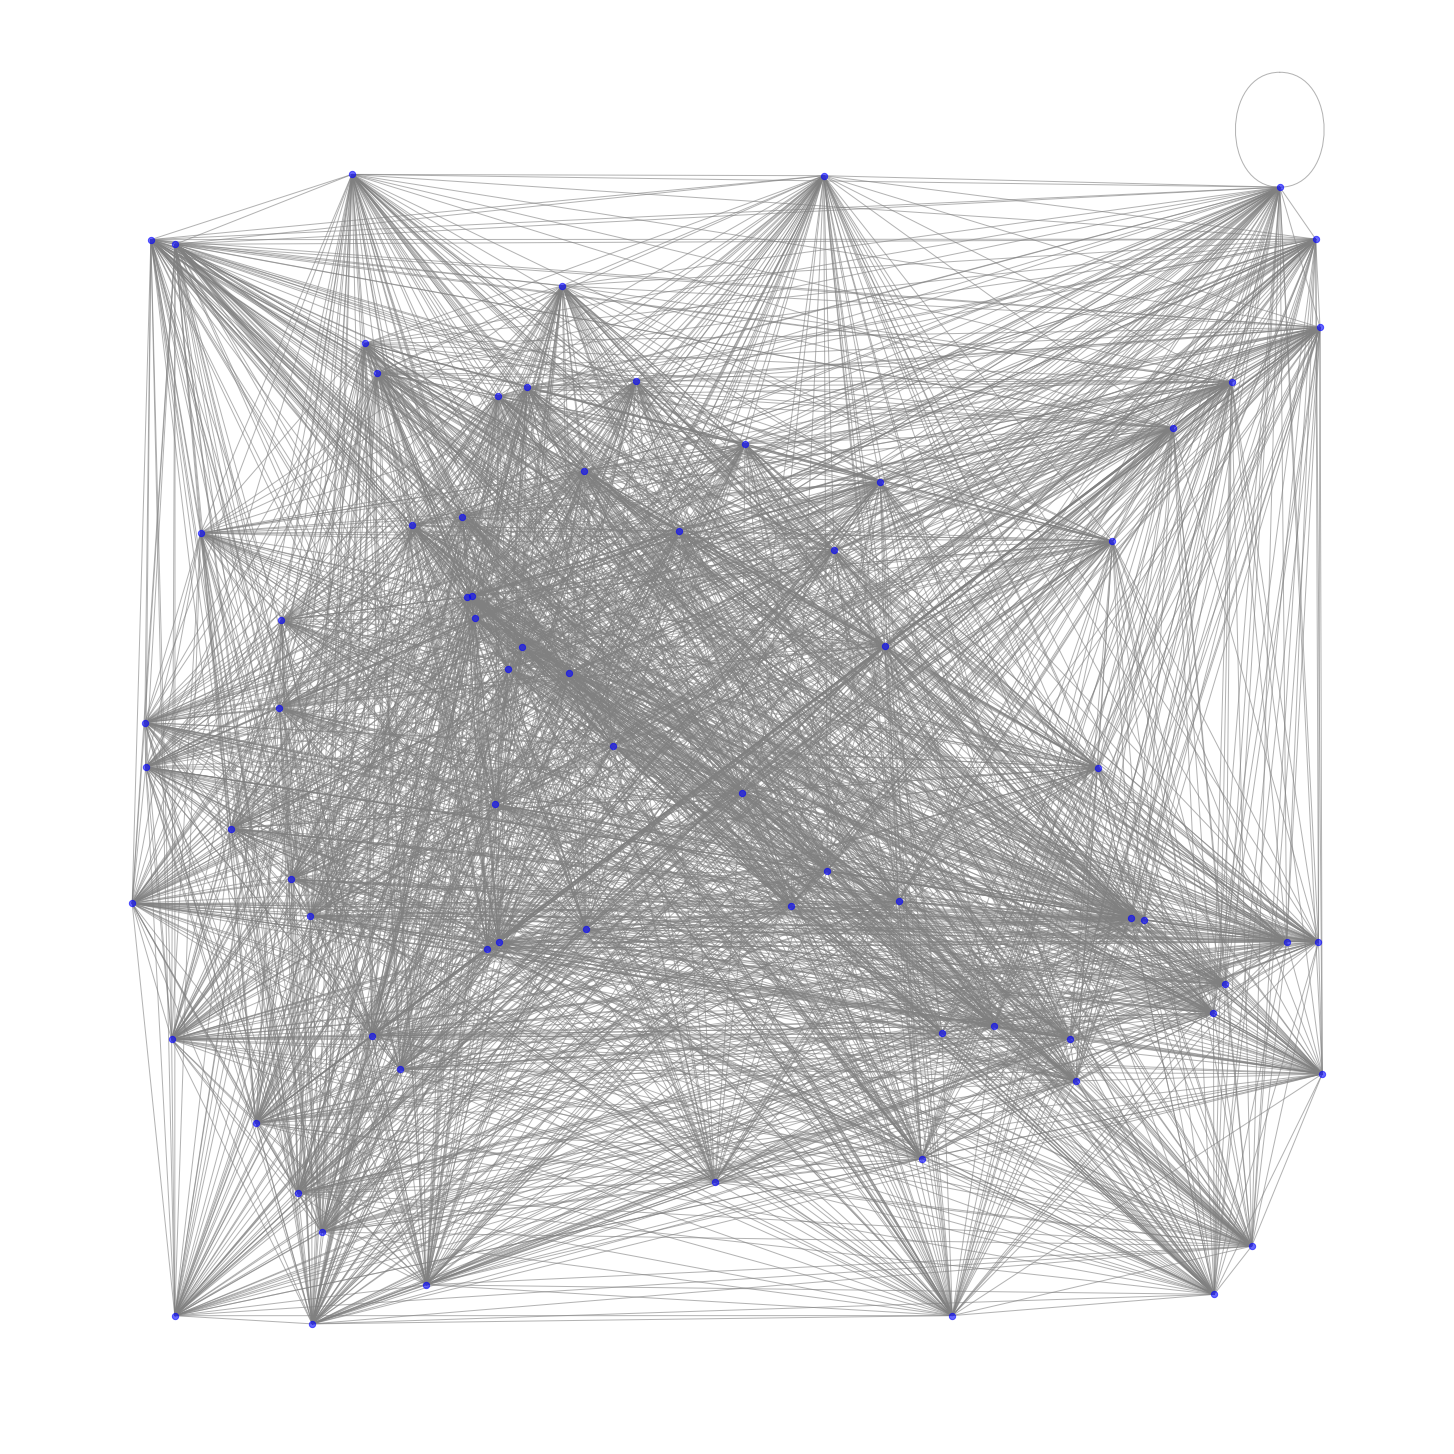

In [10]:
graph=nx.from_pandas_edgelist(marvel_universe,'hero1','hero2',create_using=nx.Graph())
plt.figure(figsize=(20,20))
pos=nx.random_layout(graph,seed=30)
nx.draw(graph, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6,edge_color='grey',node_color='blue')
plt.show()


In [11]:
hero1=set(marvel_universe['hero1'].unique())
hero2=set(marvel_universe['hero2'].unique())

In [12]:
heros=list(hero1.union(hero2))
no_of_heros=len(heros)

In [13]:
adj_mat=nx.to_numpy_array(graph,nodelist=heros)
adj_mat.shape

(74, 74)

In [14]:
unconnected_heros=[]
count=0
for i in tqdm(range(no_of_heros)):
    for j in range(count,no_of_heros):
        if(i!=j):
            try:
                if(nx.shortest_path_length(graph,heros[i],heros[j])<=2):
                    if adj_mat[i,j]==0:
                        unconnected_heros.append([heros[i],heros[j]])
            except:
                continue
    count+=1

100%|██████████| 74/74 [00:00<00:00, 1441.03it/s]


In [15]:
len(unconnected_heros)

113

In [16]:
unconnected_heros_node1=[]
unconnected_heros_node2=[]
for hero in unconnected_heros:
    unconnected_heros_node1.append(hero[0])
    unconnected_heros_node2.append(hero[1])

In [17]:
unconnected_heros_df=pd.DataFrame({'unconnected_hero1':unconnected_heros_node1,'unconnected_hero2':unconnected_heros_node2})
unconnected_heros_df['edge']=0

In [18]:
unconnected_heros_df

unconnected_hero1     unconnected_hero2  edge
0          ROBERTSON, JOE   COOPER, DR. VALERIE     0
1          ROBERTSON, JOE    POLARIS/LORNA DANE     0
2          ROBERTSON, JOE  BANSHEE/SEAN CASSIDY     0
3          ROBERTSON, JOE   HAVOK/ALEX SUMMERS      0
4          ROBERTSON, JOE  SHADOWCAT/KATHERINE      0
..                    ...                   ...   ...
108  JONES, RICHARD MILHO    NOVA/RICHARD RIDER     0
109  IRON FIST/DANIEL RAN  THUNDERSTRIKE/ERIC K     0
110  IRON FIST/DANIEL RAN  WOLFSBANE/RAHNE SINC     0
111  THUNDERSTRIKE/ERIC K     JAMESON, J. JONAH     0
112                  UATU  MOCKINGBIRD/DR. BARB     0

[113 rows x 3 columns]

In [19]:
edges_to_remove=[]
temp_df=marvel_universe.copy()
count=0
for i in tqdm(marvel_universe.index.values):
    temp=nx.from_pandas_edgelist(temp_df.drop(index=i),'hero1','hero2',create_using=nx.Graph())
    if(nx.number_connected_components(temp)==1 and len(temp.nodes)==no_of_heros):
        count+=1
        if(count>=10):
            count=0
            continue
        edges_to_remove.append(i)
        temp_df=temp_df.drop(index=i)

100%|██████████| 95620/95620 [1:38:51<00:00, 16.12it/s]  


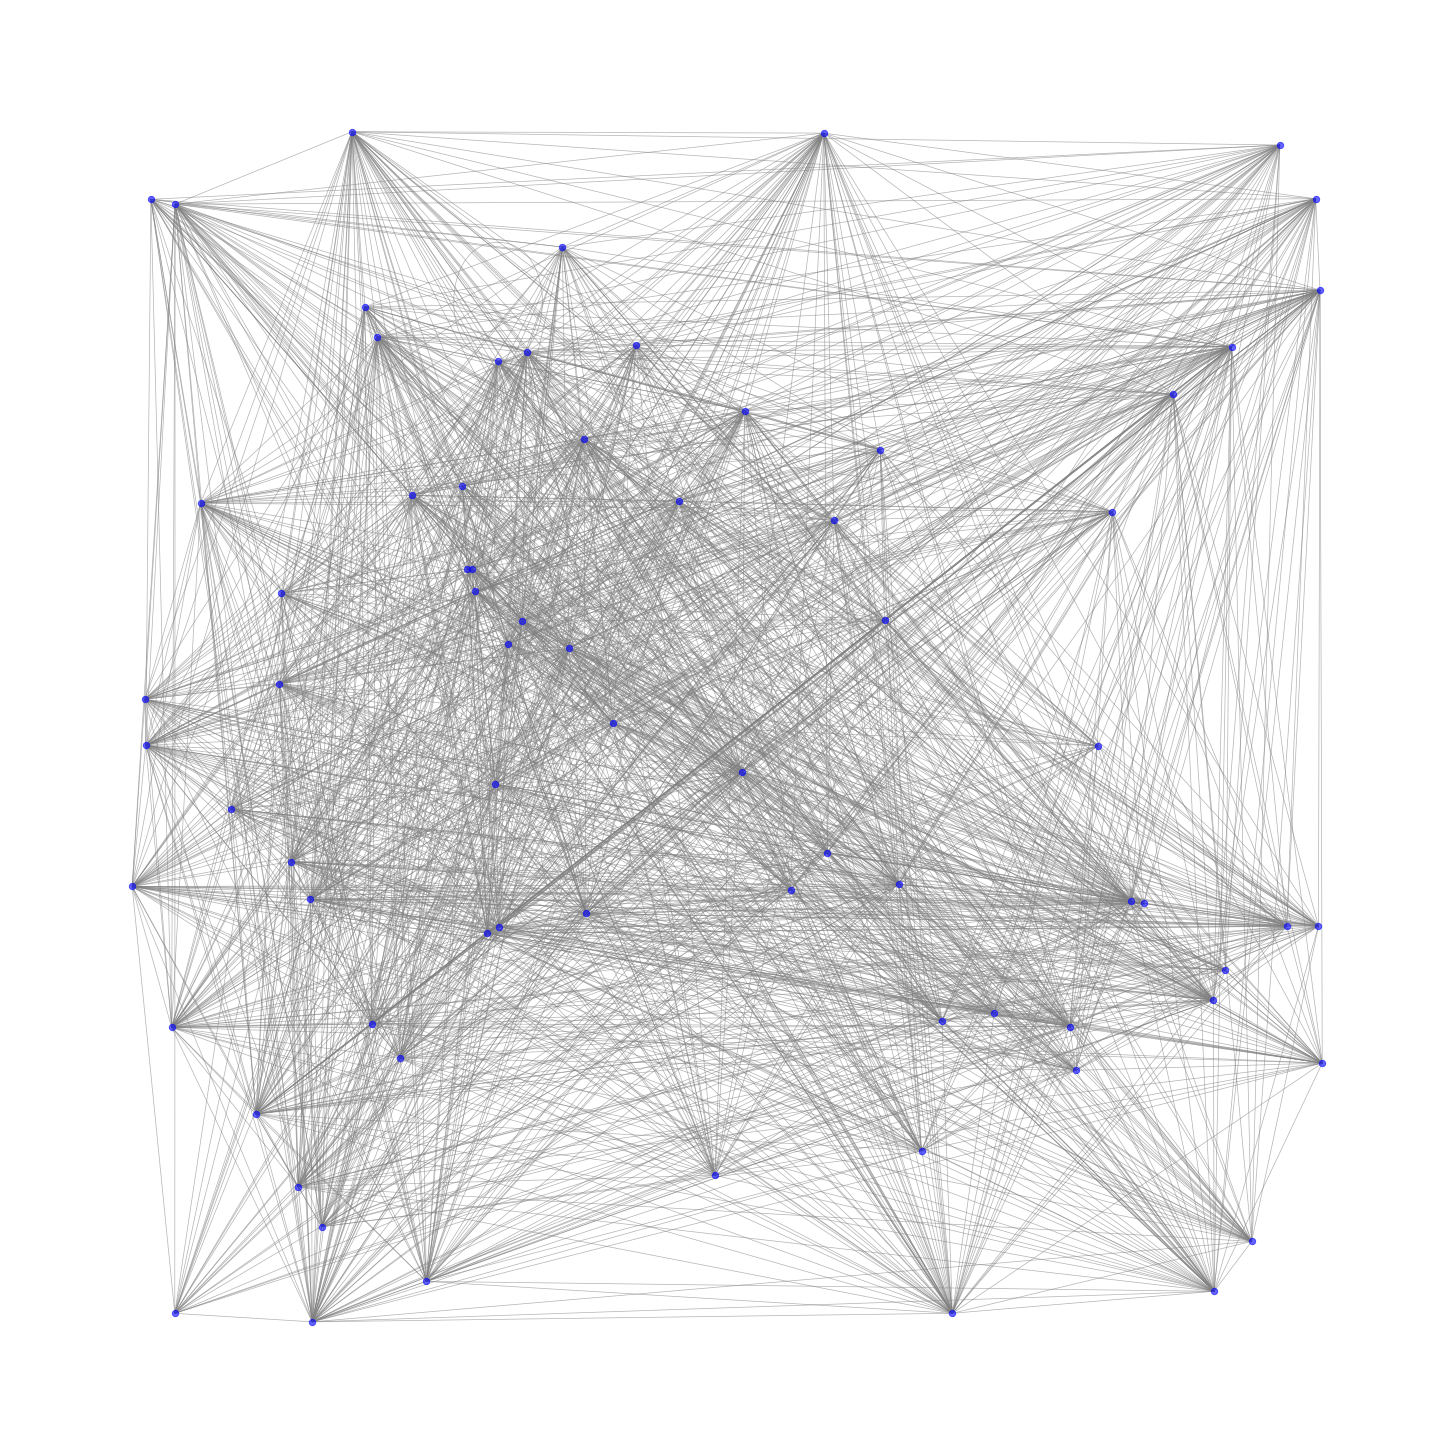

In [20]:
plt.figure(figsize=(20,20))
pos=nx.random_layout(temp,seed=30)
nx.draw(temp, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7,edge_color='grey',node_color='blue')
plt.show()


In [21]:
disconnected_heros=marvel_universe.loc[edges_to_remove]
disconnected_heros.rename(columns={'hero1':'unconnected_hero1','hero2':'unconnected_hero2'},inplace=True)
disconnected_heros['edge']=1
unconnected_heros_df=pd.concat([disconnected_heros,unconnected_heros_df],ignore_index=True)

In [22]:
unconnected_heros_df['edge'].value_counts()

1    86058
0      113
Name: edge, dtype: int64

In [23]:
modified_marvel_universe=marvel_universe.drop(index=disconnected_heros.index.values)
new_graph=nx.from_pandas_edgelist(modified_marvel_universe,'hero1','hero2',create_using=nx.Graph())

In [24]:
set1=set(unconnected_heros_df['unconnected_hero1'].unique())
set2=set(unconnected_heros_df['unconnected_hero2'].unique())
elem=list(set1.union(set2))
dicti={}
i=0
for item in elem:
    dicti[item]=i
    i+=1
print(dicti)


{'INVISIBLE WOMAN/SUE ': 0, 'ROBERTSON, JOE': 1, 'CYCLOPS/SCOTT SUMMER': 2, 'SUMMERS, NATHAN CHRI': 3, 'WONDER MAN/SIMON WIL': 4, "BLACK PANTHER/T'CHAL": 5, 'COOPER, DR. VALERIE': 6, 'RICHARDS, FRANKLIN B': 7, 'CANNONBALL II/SAM GU': 8, 'FIRESTAR/ANGELICA JO': 9, 'SUB-MARINER/NAMOR MA': 10, 'POLARIS/LORNA DANE': 11, 'DR. DOOM/VICTOR VON ': 12, 'HERCULES [GREEK GOD]': 13, 'SHE-HULK/JENNIFER WA': 14, 'WATSON-PARKER, MARY ': 15, 'USAGENT/CAPTAIN JOHN': 16, 'HULK/DR. ROBERT BRUC': 17, 'BANSHEE/SEAN CASSIDY': 18, 'CRYSTAL [INHUMAN]': 19, 'BLACK WIDOW/NATASHA ': 20, 'HAVOK/ALEX SUMMERS ': 21, 'THOR/DR. DONALD BLAK': 22, 'DAREDEVIL/MATT MURDO': 23, 'GAMBIT/REMY LEBEAU ': 24, 'SHADOWCAT/KATHERINE ': 25, 'WASP/JANET VAN DYNE ': 26, 'MR. FANTASTIC/REED R': 27, 'CAGE, LUKE/CARL LUCA': 28, 'BINARY/CAROL DANVERS': 29, 'FURY, COL. NICHOLAS ': 30, 'TIGRA/GREER NELSON': 31, 'PSYLOCKE/ELISABETH B': 32, 'MARVEL GIRL/JEAN GRE': 33, 'COLOSSUS II/PETER RA': 34, 'SUNSPOT/ROBERTO DACO': 35, 'CAPTAIN MARVEL I

In [25]:
unconnected_heros_df['unconnected_hero1']=unconnected_heros_df['unconnected_hero1'].apply(lambda x: dicti[x])
unconnected_heros_df['unconnected_hero2']=unconnected_heros_df['unconnected_hero2'].apply(lambda x: dicti[x])

In [28]:
Xtrain, Xtest, ytrain, ytest=train_test_split(unconnected_heros_df.iloc[:,:2],unconnected_heros_df['edge'],test_size=0.3)

In [29]:
regressor=LogisticRegression(solver='newton-cg',class_weight="balanced")
regressor.fit(Xtrain,ytrain)

LogisticRegression(class_weight='balanced', solver='newton-cg')

In [30]:
prediction=regressor.predict(Xtest)

In [41]:
# model=XGBClassifier(class_weight="balanced")
# model.fit(Xtrain,ytrain)

In [34]:
predictions = regressor.predict_proba(Xtest)

In [35]:
roc_auc_score(ytest, predictions[:,1])

0.7867681226765798